In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pandas as pd
import os

### Config

In [14]:
folder_path = 'measurements/'
columns_to_keep = ['QPS', 'p95', 'target']
dfs = {}
grouped_dfs = {interference_type: [] for interference_type in ['cpu', 'l1d', 'l1i', 'l2', 'llc', 'membw', 'none']}

### Load Data

In [15]:
for file in os.listdir(folder_path):
    if file.endswith('.raw') and ('-0' not in file):
        file_path = os.path.join(folder_path, file)
        parts = file.split('-')
        interference_type = parts[1]
        run_number = parts[2].split('.')[0]
        data = pd.read_csv(file_path, sep=r'\s+', usecols=columns_to_keep, skipfooter=2, engine='python')
        dfs[f'{interference_type}_{run_number}'] = data

### Plot 1

[]

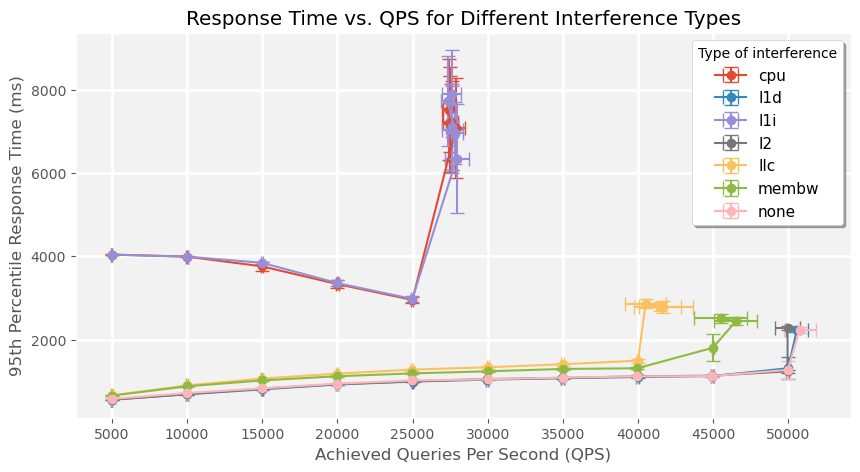

In [42]:
# Plot Style
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

for key in sorted(dfs.keys()):
    parts = key.split('_')
    interference_type = '_'.join(parts[:-1])
    run_number = parts[-1]
    
    if interference_type in grouped_dfs:
        grouped_dfs[interference_type].append(dfs[key])

for interference_type, df_list in grouped_dfs.items():
    p95_means = list()
    p95_stds = list()
    qps_means = list()
    qps_stds = list()
    
    target_qps_levels = df_list[0]['target'].values if df_list else []
    
    for target_qps in target_qps_levels:
        # Gather p95 and QPS values for the current target QPS across all runs
        p95_values = [df[df['target'] == target_qps]['p95'].values[0] for df in df_list]
        qps_values = [df[df['target'] == target_qps]['QPS'].values[0] for df in df_list]
        
        # Calculate the mean and standard deviation for the current target QPS
        p95_means.append(np.mean(p95_values))
        p95_stds.append(np.std(p95_values, ddof=1))
        qps_means.append(np.mean(qps_values))
        qps_stds.append(np.std(qps_values, ddof=1))
    
    ax.errorbar(qps_means, p95_means, xerr=qps_stds, yerr=p95_stds, fmt='o-', capsize=5, label=interference_type)
, bbox_to_anchor=(0.5, 1.17),

ax.set_facecolor((0.95,0.95,0.95))
ax.grid(which='major', color='white', linewidth=2)

# Plot Style
ax.set_xlabel('Achieved Queries Per Second (QPS)')
ax.set_ylabel('95th Percentile Response Time (ms)')
ax.set_title('Response Time vs. QPS for Different Interference Types')
ax.legend(title='Type of interference', shadow=True, facecolor='white')
plt.xticks(range(5000, 55000, 5000))
plt.plot()
#plt.savefig("plots/plot1.pdf")